# 0. Imports

In [2]:
# 1. Data Loading
import pandas as pd
import numpy as np

# 2. Análise Exploratória
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Classificação usando 'assuntos' e 'documentos'
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

# 4. Feature Extraction - (TFIDF)
import re
import unicodedata
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package stopwords to /home/esdras-
[nltk_data]     daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/esdras-
[nltk_data]     daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/esdras-
[nltk_data]     daniel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 1. Data Loading

In [3]:
df = pd.read_csv('./data/pgm-dataset-v3.csv', sep=',', encoding='')
print(f'Shape: {df.shape}')

df.head(3)

Shape: (15942, 10)


,teorTexto,idAviso,setorDestino,dataAviso,tipoAviso,orgaoJulgador,assuntos,documentos,anexos,classeProcesso
0,PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,18612632.0,Procuradoria da Sa�de,2024-06-21 05:00:40,IntimaÆo,2ª Vara da Infância e Juventude da Comarca de ...,12485;12494,Decisão;Petição de manifestação;Despacho;Certi...,notaTecnica-228951.pdf - notaTecnica-228951;E-...,1706
1,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,18629258.0,Procuradoria Administrativa,2024-06-25 23:59:59,IntimaÆo,3º Juizado da Fazenda Pública da Comarca de Natal,10715,Notificação;Petição;Despacho;Diligência;Notifi...,FICHA FINANCEIRA;SEMAD - Joelma;08464942120228...,14695
2,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,18629422.0,CARTORIO,2024-06-18 09:27:16,IntimaÆo,3ª Vara de Execução Fiscal e Tributária de Natal,10536;5952,Certidão;Certidão;Sentença;Petição;Intimação;C...,"0895416-93.2022, AR;Certidão de Dívida Ativa;C...",1116


## 1.1 - Identificando e tratando valores nulos

### 1.1.1 - Removendo linhas onde 'setorDestino' é nulo

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15942 entries, 0 to 15941
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   teorTexto       15942 non-null  object 
 1   idAviso         15356 non-null  float64
 2   setorDestino    15356 non-null  object 
 3   dataAviso       15942 non-null  object 
 4   tipoAviso       15942 non-null  object 
 5   orgaoJulgador   15942 non-null  object 
 6   assuntos        15939 non-null  object 
 7   documentos      15553 non-null  object 
 8   anexos          15521 non-null  object 
 9   classeProcesso  15942 non-null  int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 1.2+ MB


In [6]:
df.isnull().sum()

teorTexto           0
idAviso           586
setorDestino      586
dataAviso           0
tipoAviso           0
orgaoJulgador       0
assuntos            3
documentos        389
anexos            421
classeProcesso      0
dtype: int64

In [7]:
# Excluindo as linhas onde setorDestino é nulo

df = df[~df['setorDestino'].isna()]

df.isna().sum()

teorTexto           0
idAviso             0
setorDestino        0
dataAviso           0
tipoAviso           0
orgaoJulgador       0
assuntos            3
documentos        383
anexos            413
classeProcesso      0
dtype: int64

### 1.1.2 - Substituindo valores nulos das colunas 'assuntos', 'documentos' e 'anexos'

In [8]:
df['assuntos'] = df['assuntos'].fillna(value='Nenhum Assunto')
df['documentos'] = df['documentos'].fillna(value='Nenhum Documento')
df['anexos'] = df['anexos'].fillna(value='Nenhum Anexo')

## 1.2 - Identificando e removendo linhas iguais

In [9]:
df[df.duplicated()].head()

,teorTexto,idAviso,setorDestino,dataAviso,tipoAviso,orgaoJulgador,assuntos,documentos,anexos,classeProcesso
845,Poder Judiciário do Estado do Rio Grande do No...,18672297.0,Procuradoria Administrativa,2024-08-01 23:59:59,IntimaÆo,5º Juizado da Fazenda Pública da Comarca de Natal,9517;10236,Petição;Despacho;Petição;Certidão;Despacho;Des...,justificativa - CLEONICE CAVALCANTE DE LIMA;ca...,12078
1039,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,18683869.0,Procuradoria Administrativa,2024-08-01 23:59:59,CitaÆo,3º Juizado da Fazenda Pública da Comarca de Natal,10357,Despacho;Dilação do prazo;Contestação;Despacho...,Processo Declaração de Licença-Prêmio;01 Docs ...,14695
1042,Poder Judiciário do Estado do Rio Grande do No...,18684449.0,Procuradoria Administrativa,2024-08-01 23:59:59,CitaÆo,5º Juizado da Fazenda Pública da Comarca de Natal,10357,Contestação do município;Despacho;Petição;Desp...,DECLARAÇÃO-ELEN DORIS;Petição - 0819420-21.202...,14695
3324,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,18808934.0,Procuradoria da Sa�de,2024-07-04 03:31:15,NotificaÆo,1ª Vara da Fazenda Pública da Comarca de Natal,12484,Diligência;Decisão;Petição;Certidão;Intimação;...,SESAP - 124839443;01.14 - Parecer NatJus dor c...,7
6937,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,18998026.0,Procuradoria Administrativa,2024-07-29 23:59:59,IntimaÆo,4º Juizado da Fazenda Pública da Comarca de Natal,10671,Petição;Certidão;Decisão;Petição;Despacho;Cert...,0811137-19.2018.8.20.5001 ExtratoDemonstrativo...,12078


In [10]:
df.drop_duplicates(inplace=True)

### 1.2.1 - Verificando quantos textos em 'teorTexto' são repetidos

In [11]:
print(f'Quantidade de textos em "teorTexto" que são repetidos: {df.duplicated(subset='teorTexto').sum()}')

Quantidade de textos em "teorTexto" que são repetidos: 470


Podemos ver que na coluna 'teorTexto' temos 470 textos repetidos, porém são processos diferentes. Por isso vamos deixar essas repetições.

## 1.3 - Agrupando setores e corrigindo erros na formatação

### 1.3.1 - Removendo textos se 'setordestino' menor que N registros

In [12]:
N = 5

df = df.groupby('setorDestino').filter(lambda x: len(x) > 5)
df.reset_index(drop=True, inplace=True)

### 1.3.2 - Agrupando setores

In [13]:
setores_mapeamento = {
    'Procuradoria Administrativa': 'Administrativa',
    'Chefia Administrativa': 'Administrativa',
    'Procuradoria Fiscal': 'Fiscal',
    'APOIO FISCAL': 'Apoio Fiscal',
    'CHEFIA FISCAL': 'Fiscal',
    'Procuradoria da Sa�de': 'Saúde',
    'Procuradoria Judicial': 'Judicial',
    'Chefia Judicial': 'Judicial',
    'Procuradoria do Meio Ambiente': 'Meio Ambiente',
    'Chefia Meio Ambiente': 'Meio Ambiente',
    'Chefia Patrimonial': 'Patrimonial',
    'DEPARTAMENTO DE C�LCULOS E CONTABILIDADE': 'Contabilidade',
    'Assessoria - Gabinete': 'Cartório',
    'Procuradoria Geral': 'Cartório'
}

df['setorDestino_agrupado'] = df['setorDestino'].map(setores_mapeamento)

In [14]:
df['setorDestino_agrupado'].value_counts()

setorDestino_agrupado
Administrativa    5393
Apoio Fiscal      4308
Fiscal            2374
Contabilidade     1338
Judicial          1137
Saúde              442
Meio Ambiente      155
Patrimonial        120
Cartório            66
Name: count, dtype: int64

### 1.3.3 - Corrigindo erros em 'tipoAviso'

In [15]:
errors_dict = {'Æ': 'ã', 
               '��': 'çã', 
               'audincia': 'audiência',
               '\x87': 'ç'}

df['tipoAviso'] = df['tipoAviso'].replace(errors_dict, regex=True)
#df['tipoAviso'].replace(errors_dict, regex=True, inplace=True)

In [16]:
df['tipoAviso'].value_counts()

tipoAviso
Intimação                 13104
Intimação de Pauta         1182
Citação                    1019
Notificação                  24
Intimação de audiência        4
Name: count, dtype: int64

# 2. Análise exploratória

Ver a distribuição de 'assuntos', 'documentos' em cada 'setorDestino_agrupado'

## 2.1 - Coluna 'assuntos'

In [17]:
def separa_assuntos_documentos(list: pd.Series, sep=';'):

    data = []

    # Popula uma lista com as separações
    for item in list:
        data.append(item.split(sep))

    # Obtendo todos os números únicos como colunas
    cols = sorted(set(num for sublist in data for num in sublist))
    print(f'Número de assuntos/documentos: {len(cols)}')

    # Criando o DataFrame Binário
    df = pd.DataFrame([{col: (col in row) * 1 for col in cols} for row in data])

    return df

df_assuntos = separa_assuntos_documentos(df['assuntos'])

# Adicionando a coluna setorDestino_agrupado
df_assuntos['setorDestino_agrupado'] = df['setorDestino_agrupado']

Número de assuntos/documentos: 488


In [19]:
sparsity = 1 - np.count_nonzero(df_assuntos.iloc[:,:-1]) / df_assuntos.iloc[:,:-1].size
print(f'Esparcidade da matriz: {sparsity:.2%}')

Esparcidade da matriz: 99.71%


In [20]:
df_assuntos_agrupados = df_assuntos.groupby('setorDestino_agrupado').sum()

In [21]:
df_assuntos_agrupados

,10006,10009,10010,10011,10012,10013,10014,10015,10023,10024,10025,10064,10069,10073,10075,10076,10083,10085,10086,10089,10090,10094,10109,10110,10111,10112,10113,10114,10116,10118,10121,10122,10123,10125,10129,10130,10132,10134,10192,10199,...,8838,8859,8919,8928,8961,8986,9148,9149,9160,9163,9178,9196,9414,9517,9518,9519,9520,9524,9532,9538,9558,9580,9581,9587,9591,9593,9596,9606,9609,9614,9966,9977,9990,9991,9992,9994,9995,9996,9998,Nenhum Assunto
setorDestino_agrupado,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Administrativa,0,1,3,2,16,9,4,1,3,0,0,0,0,7,0,17,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,...,0,0,1,0,9,0,0,4,1,0,2,10,19,621,11,1,1,0,0,0,0,2,0,0,1,1,3,1,0,1,1,0,0,0,17,0,0,0,1,0
Apoio Fiscal,0,0,0,1,0,0,0,0,149,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,121,0,0,0,0,2,3,4,0,1,8,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cartório,0,0,0,0,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,11,1,0,0,0,0,0
Contabilidade,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,11,0,0,4,1,1,1,1,23,584,7,0,0,1,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,71,0,1,6,0,0
Fiscal,1,0,0,0,1,0,1,1,66,0,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,...,0,2,7,1,29,0,3,0,0,25,107,20,6,10,154,0,0,0,9,2,4,0,0,1,0,0,0,0,1,0,0,0,1,0,8,0,0,1,0,3
Judicial,0,0,0,0,2,0,1,1,24,0,15,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,1,0,0,1,2,90,4,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,522,0,0,19,0,0
Meio Ambiente,0,0,0,0,0,0,0,0,4,2,0,0,0,0,0,0,0,1,1,0,1,0,1,3,1,1,1,1,2,1,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,3,0,0,0,0,0,5,5,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,4,0,0,0,0
Patrimonial,0,2,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,2,1,0,12,2,1,3,1,1,0,4,0,0,...,0,0,0,0,1,0,0,0,0,0,0,2,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0
Saúde,0,0,0,0,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,1,0,0,0,0,0,2,0,6,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,16,1,0,0


In [22]:
# Função personalizada para exibir porcentagem e valor absoluto
def autopct_format(pct, all_vals):
    absolute = int(round(pct / 100. * sum(all_vals)))  # Calcula o valor real
    return f"{pct:.1f}%\n({absolute})"  # Retorna ambos formatados

def plot_most_subjects_per_class(df, N=6):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    # Percorrendo as 9 classes e criando os gráficos
    for i, (classe, valores) in enumerate(df.iterrows()):
        ax = axes[i // 3, i % 3]
        
        # Pegando os N princiáis assuntos + 'Outros'
        top_N = valores.nlargest(N)
        outros = valores.drop(top_N.index).sum()

        # Criando o dicionário para o gráfico de pizza
        data_plot = top_N.to_dict()
        data_plot['Outros'] = outros

         # Criando o gráfico
        ax.pie(data_plot.values(), labels=data_plot.keys(), autopct=lambda pct: autopct_format(pct, data_plot.values()), 
           colors=plt.cm.Paired.colors, startangle=90)
        ax.set_title(f"Classe {classe}")
    
    plt.tight_layout()
    plt.show()

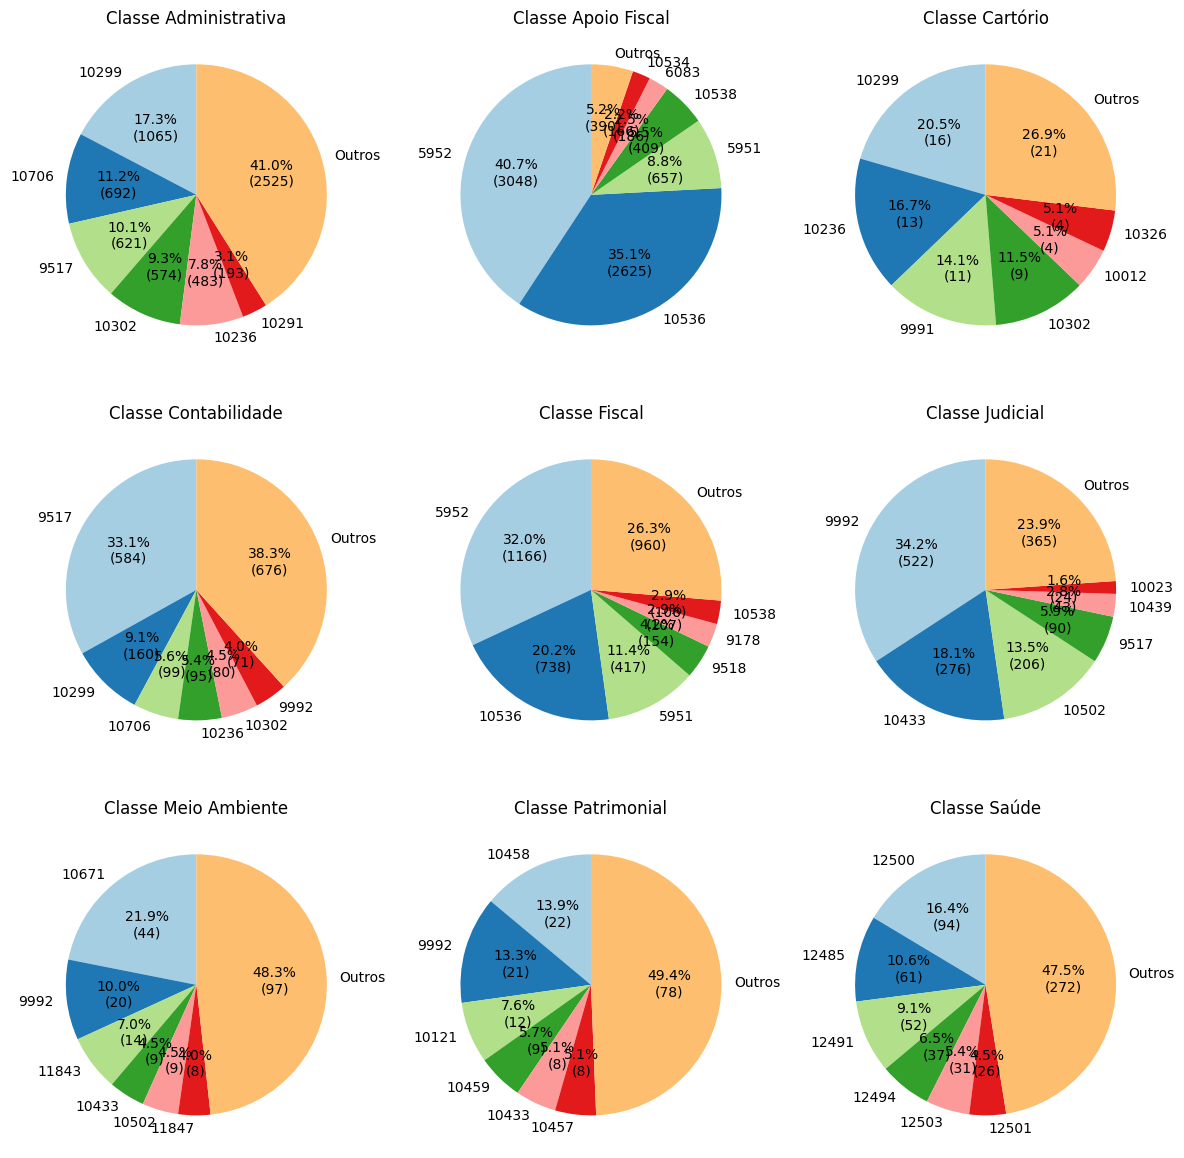

In [23]:
plot_most_subjects_per_class(df_assuntos_agrupados, N=6)

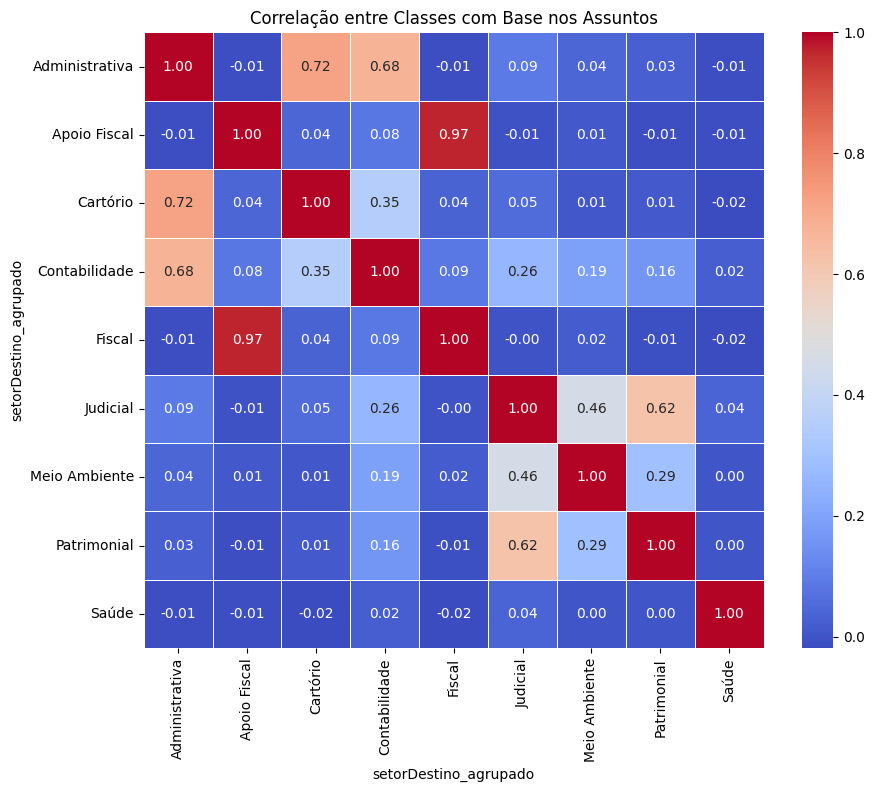

In [24]:
# Calcula a matriz de correlação entre as classes
correlation_matrix = df_assuntos_agrupados.T.corr()

# Plotando o heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlação entre Classes com Base nos Assuntos")
plt.show()

## 2.2 - Coluna 'documentos'

In [25]:
df_documentos = separa_assuntos_documentos(df['documentos'])

# Adicionando a coluna setorDestino_agrupado
df_documentos['setorDestino_agrupado'] = df['setorDestino_agrupado']

Número de assuntos/documentos: 9650


In [26]:
sparsity = 1 - np.count_nonzero(df_documentos.iloc[:,:-1]) / df_documentos.iloc[:,:-1].size
print(f'Esparcidade da matriz: {sparsity:.2%}')

Esparcidade da matriz: 99.86%


In [27]:
df_documentos_agrupados = df_documentos.groupby('setorDestino_agrupado').sum()

In [28]:
df_documentos_agrupados

,,"R$ 0,00 a R$ 5.000,00","R$ 1.300.000,01 a R$ 1.320.000,00","R$ 10.000,01 a R$ 15.000,00","R$ 100.000,01 a R$ 120.000,00","R$ 120.000,01 a R$ 140.000,00","R$ 15.000,01 a R$ 20.000,00","R$ 160.000,01 a R$ 180.000,00","R$ 180.000,01 a R$ 200.000,00","R$ 20.000,01 a R$ 25.000,00","R$ 200.000,01 a R$ 220.000,00","R$ 240.000,01 a R$ 260.000,00","R$ 25.000,01 a R$ 30.000,00","R$ 30.000,01 a R$ 35.000,00","R$ 35.000,01 a R$ 40.000,00","R$ 40.000,01 a R$ 45.000,00","R$ 440.000,01 a R$ 460.000,00","R$ 45.000,01 a R$ 50.000,00","R$ 5.000,01 a R$ 10.000,00","R$ 50.000,01 a R$ 55.000,00","R$ 55.000,01 a R$ 60.000,00","R$ 65.000,01 a R$ 70.000,00","R$ 70.000,01 a R$ 75.000,00","R$ 75.000,01 a R$ 80.000,00","R$ 80.000,01 a R$ 85.000,00","R$ 85.000,01 a R$ 90.000,00","R$ 90.000,01 a R$ 95.000,00","R$0 até R$500,00","R$1000,01 até R$1500,00","R$18000,01 até R$19000,00","R$2000,01 até R$2500,00","R$26000,01 até R$27000,00","R$27000,01 até R$28000,00","R$29000,01 até R$30000,00","R$3000,01 até R$3500,00","R$32000,01 até R$33000,00","R$4500,01 até R$5000,00","R$5000,01 até R$5500,00","R$8000,01 até R$8500,00",# PETIÇÃO INICIAL - Gilton Cachina Bezerra,...,resposta de ofício,resposta de ofício - desbloqueio e depósito judicial,retificar instrumento precatório,retirada das restrições de circulação sobre o veículo de propriedade do executado,réplica,réplica + reiteração pedido tutela antecipada,réplica a contestação,réplica certa,réplica e pronunciamento sobre documentos apresentados pelo Município,réplica à contestaçao,réplica à contestação,réplica à impugnação.,se manifestar sobre a certidão do Oficial de Justiça,sem cumprimento,sem interesse,sem intervenção,sentença (cópia),sequencial acobertado no parcelamento - mudança de ofiio,sisbajud negativo,sisbajud sem sucesso,sisbajud sucesso parcial,sobre impugnação,sobre perícia,solicita devoução das perícias - NUPEJ,solicita o bloqueio online,solicitação de habilitação,substabelecimento,tempestividade,"tomar ciência da decisão, prestar informações e juntar documentos.",trânsito em julgado,trânsito em julgado do processo / Acórdão do Agravo de Instrumento,tutela de urgência,urgente,urgente desbloqueio,valores residuais,"whatsapp e e-mail da autora, do advogado e da primeira requerida",Impugnação,ÓBITO DA PARTE AUTORA / Habilitação de herdeiras,à Apelação,óbito antes da citação
setorDestino_agrupado,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Administrativa,10,21,0,2,1,2,1,0,1,0,4,1,0,1,0,0,0,0,2,1,1,1,7,0,2,1,1,0,2,0,0,0,0,0,0,0,1,0,0,2,...,0,0,0,0,8,1,0,1,0,0,1,0,0,0,15,6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Apoio Fiscal,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
Cartório,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Contabilidade,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fiscal,5,7,1,7,0,1,0,2,0,5,0,0,4,2,1,1,1,2,15,5,6,1,0,11,0,0,0,2,0,0,3,1,0,0,1,0,0,1,2,0,...,0,1,0,1,4,0,0,0,4,1,0,1,2,0,8,5,1,2,0,1,0,1,1,1,0,0,0,0,0,1,3,1,0,0,2,0,1,0,1,0
Judicial,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Meio Ambiente,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Patrimonial,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Saúde,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,

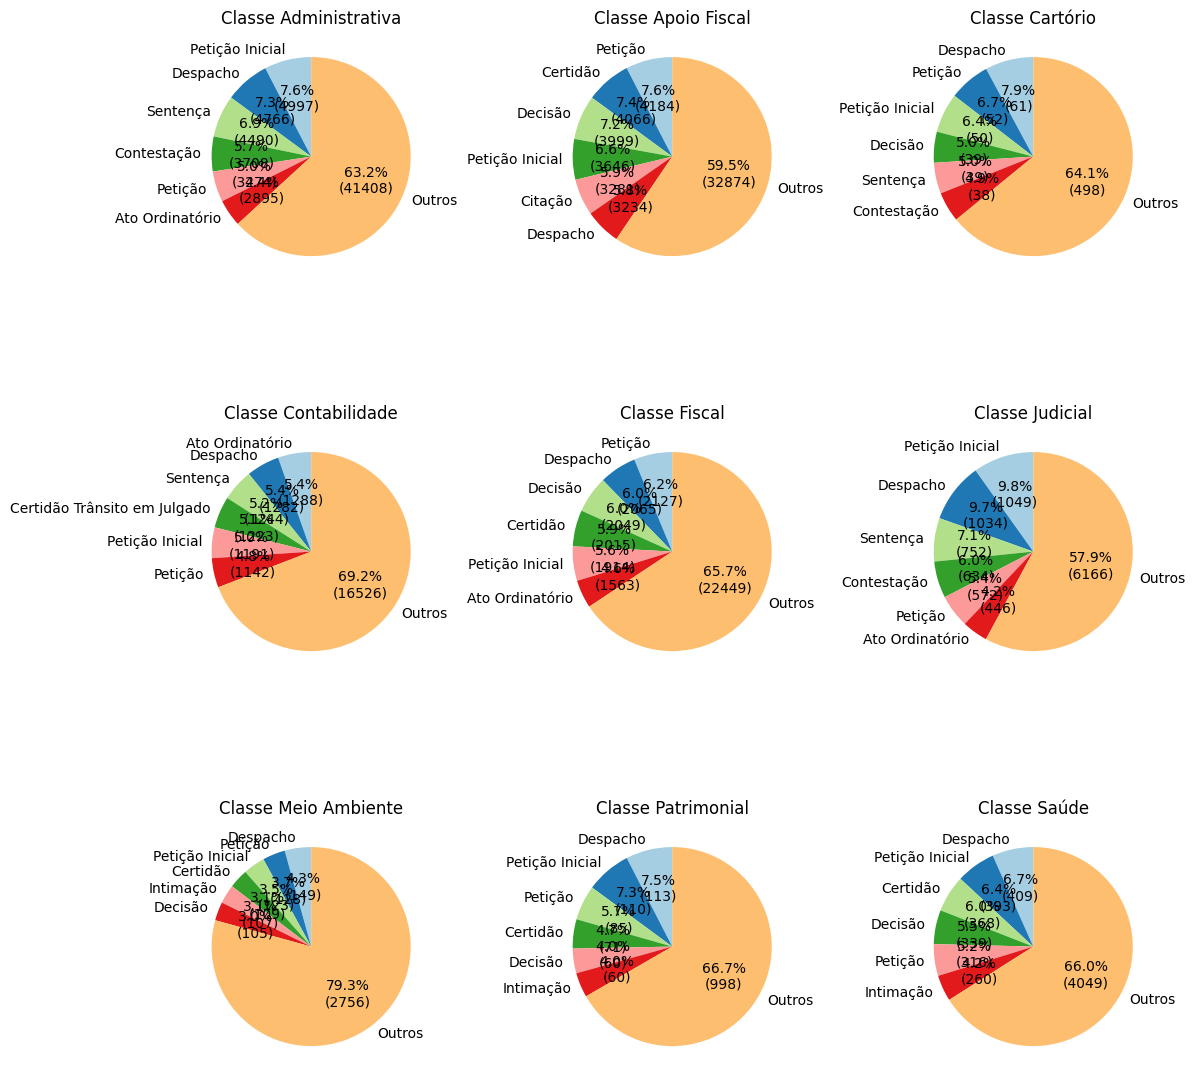

In [29]:
plot_most_subjects_per_class(df_documentos_agrupados, N=6)

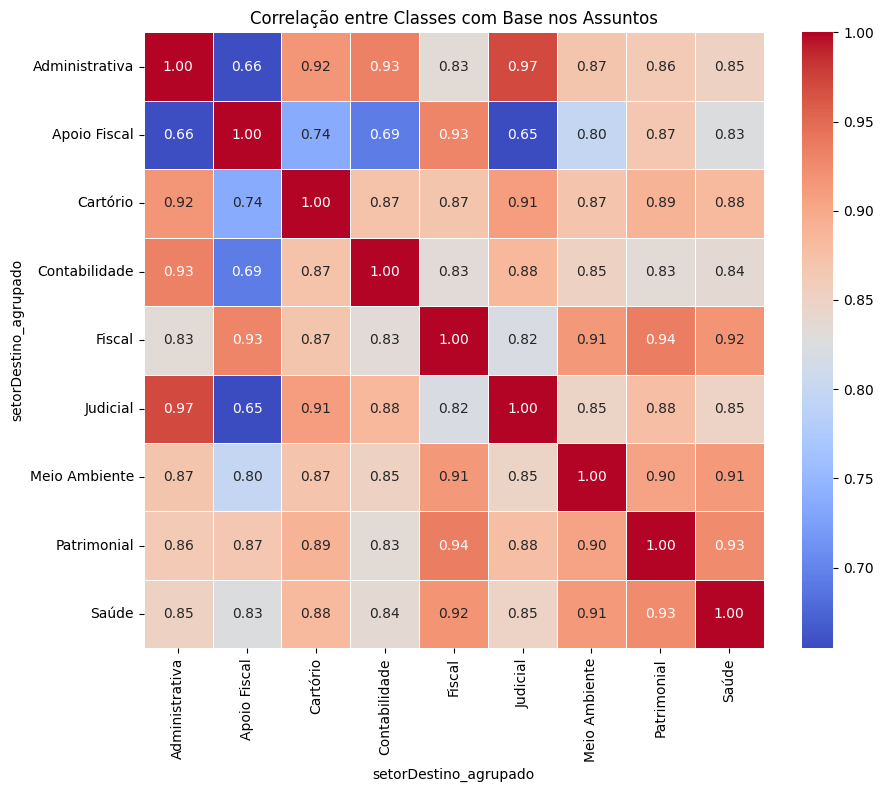

In [30]:
# Calcula a matriz de correlação entre as classes
correlation_matrix = df_documentos_agrupados.T.corr()

# Plotando o heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlação entre Classes com Base nos Assuntos")
plt.show()

# 3. Classificação usando 'assuntos' e 'documentos'

## 3.0 - Funções

In [31]:
def plot_confusion_matrix(y_test, y_pred, class_names):
    # Calcula a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Normaliza a matriz para valores entre 0 e 1
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Cria o gráfico
    plt.figure(figsize=(10, 8))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão', fontsize=16)
    plt.colorbar()
    
    # Adiciona rótulos
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=6)
    plt.yticks(tick_marks, class_names, fontsize=8)
    
    # Adiciona os valores na matriz
    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.2f})',
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black",
                 fontsize=10)
    
    plt.ylabel('Classe Real', fontsize=14)
    plt.xlabel('Classe Prevista', fontsize=14)
    plt.tight_layout()
    plt.show()

## 3.1 - Balanceamento de classes

In [32]:
def balanceamento_de_classes(df, classes, n_docs_max = 500):
    """
    Ajusta o número de amostras máximas para cada classe em um DataFrame. 
    Caso uma classe não tenha o número máximo de documentos, considera-se todos os documentos da classe.

    Parâmetros:
    - df (pd.DataFrame): DataFrame original.
    - classes (str): Nome da coluna que contém as classes.
    - n_docs (int): Número desejado de documentos por classe.
    
    Retorno:
    - pd.DataFrame: DataFrame ajustado com a quantidade especificada de documentos por classe.
    """

    df_return = pd.DataFrame()

    for classe in np.unique(df[classes]):
        df_temp = df[df['setorDestino_agrupado'] == classe]

        if len(df_temp) > n_docs_max:
            df_return = pd.concat([df_return, df_temp.sample(n_docs_max, random_state=42)])
        else:
            df_return = pd.concat([df_return, df_temp.sample(frac=1, random_state=42)])

    df_return = df_return.sample(frac=1, random_state=42)
    
    return df_return

N = 500

df_assuntos_balanceado = balanceamento_de_classes(df_assuntos, 'setorDestino_agrupado', n_docs_max=N)
df_documentos_balanceado = balanceamento_de_classes(df_documentos, 'setorDestino_agrupado', n_docs_max=N)

## 3.2 - Train Test Split

In [33]:
X_assunto = df_assuntos_balanceado.iloc[:,:-1].to_numpy()
X_documento = df_documentos_balanceado.iloc[:,:-1].to_numpy()
y = df_assuntos_balanceado.iloc[:,-1].to_numpy()

X_assunto_train, X_assunto_test, y_train, y_test = train_test_split(X_assunto, y, test_size=0.3, random_state=42, stratify=y)
X_documento_train, X_documento_test, _, _ = train_test_split(X_documento, y, test_size=0.3, random_state=42, stratify=y)

## 3.3 - Classificação por Assunto

In [34]:
svm_cls = LinearSVC()
svm_cls.fit(X_assunto_train, y_train)

y_pred = svm_cls.predict(X=X_assunto_test)

In [35]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                precision    recall  f1-score   support

Administrativa       0.55      0.83      0.66       150
  Apoio Fiscal       0.67      0.73      0.70       150
      Cartório       1.00      0.25      0.40        20
 Contabilidade       0.66      0.46      0.54       150
        Fiscal       0.61      0.61      0.61       150
      Judicial       0.74      0.75      0.75       150
 Meio Ambiente       0.69      0.52      0.59        46
   Patrimonial       0.95      0.58      0.72        36
         Saúde       0.95      0.91      0.93       133

      accuracy                           0.69       985
     macro avg       0.76      0.63      0.66       985
  weighted avg       0.71      0.69      0.68       985



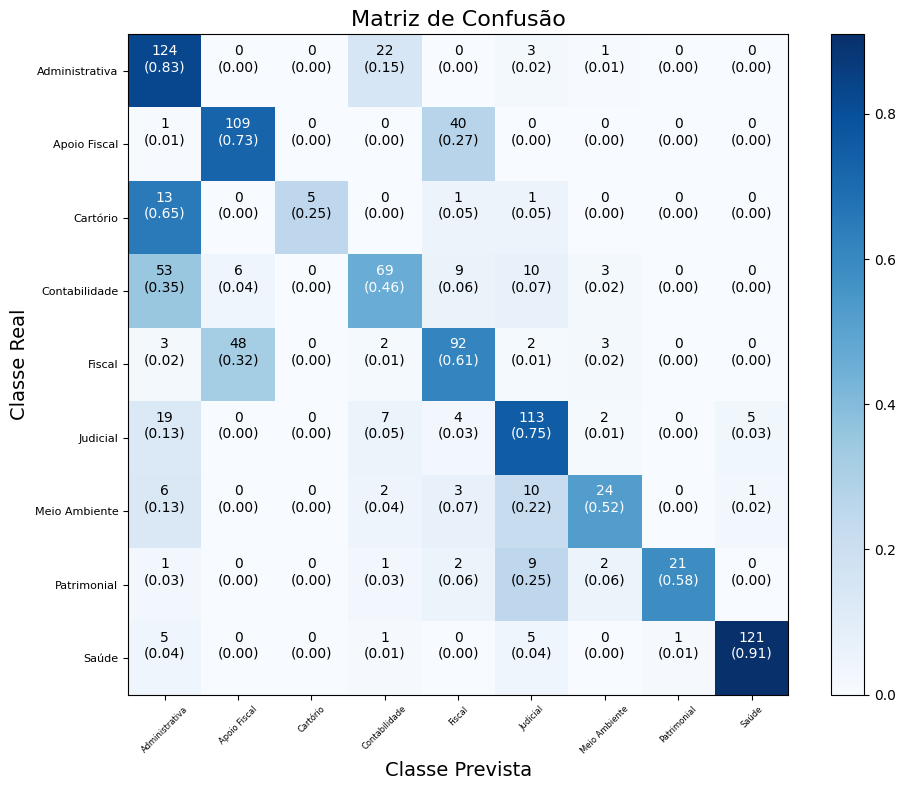

In [36]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=np.unique(y_train))

## 3.4 - Classificação por Documento

In [37]:
svm_cls = LinearSVC()
svm_cls.fit(X_documento_train, y_train)

y_pred = svm_cls.predict(X=X_documento_test)

In [38]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                precision    recall  f1-score   support

Administrativa       0.62      0.60      0.61       150
  Apoio Fiscal       0.75      0.81      0.78       150
      Cartório       0.86      0.30      0.44        20
 Contabilidade       0.72      0.77      0.75       150
        Fiscal       0.66      0.61      0.63       150
      Judicial       0.52      0.67      0.59       150
 Meio Ambiente       0.67      0.39      0.49        46
   Patrimonial       0.75      0.50      0.60        36
         Saúde       0.86      0.83      0.84       133

      accuracy                           0.68       985
     macro avg       0.71      0.61      0.64       985
  weighted avg       0.69      0.68      0.68       985



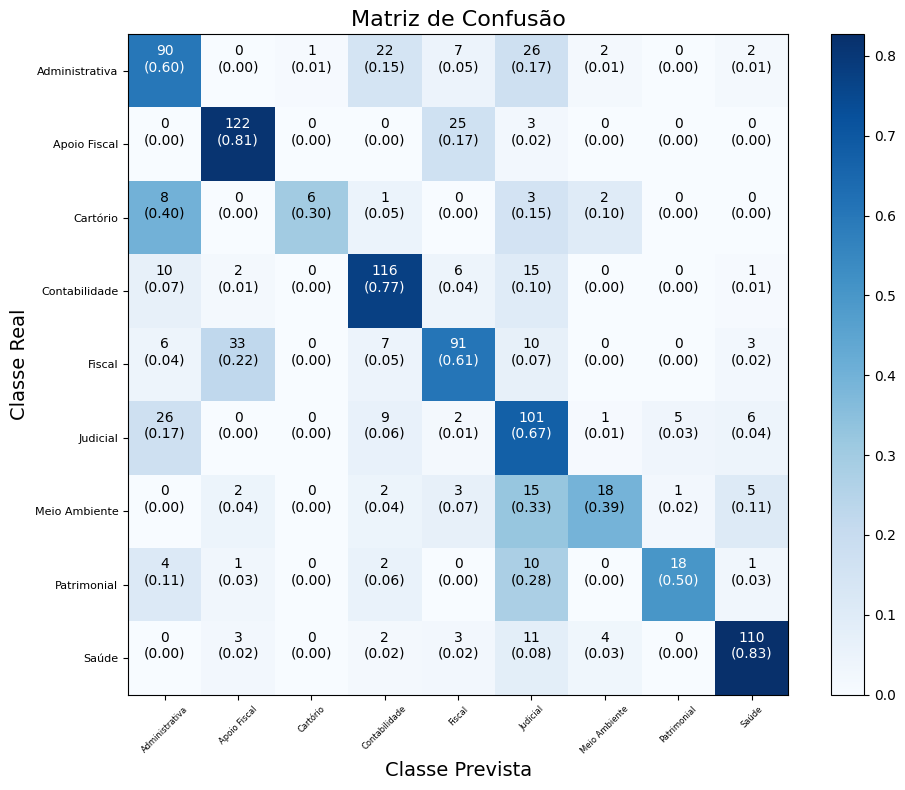

In [39]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=np.unique(y_train))

# 4. Feature Extraction - (TFIDF)

## 4.1 - Pré-processamento dos textos 

In [40]:
stop_words_pt = set(stopwords.words('portuguese'))

padroes = ['[^\w\s]',
        'poder judiciario do estado do rio grande do norte',
        'poder judiciario estado do rio grande do norte',
        'poder judiciario do estado rio grande do norte',
        'poder judiciario estado rio grande do norte',
        'normal', 'false',
            'ptbr', 'xnone',
            'poder', 'judiciario',
            'estado', 'rio', 'grande', 'norte',
            'vara execucao fiscal',
            'tributaria natal',
            'praca sete setembro',
            'cidade alta',
            'natalrn', 'cep',
            'rn', 'natal', '5902530',
            'assinado', 'digitalmente',
            'forma lei', 'n1141906',
            'comarca', 'forum fazendario',
            'juiz djanirito souza moura',
            'data registrada sistema',
            '1141906', 'veft', '59025275', 'email',
            'secuniefttj', 'jusbr',
            'telefone', 'whatsapp',
            '36738671',
            'judiciario', 'natalpraca',
            'setembro', 'cidade', '59025300',
            'rio norte', 'forum fazendario',
            'juiz', 'djanirito souza mouro',
            'praca alto', 'natalrn', 'nao',
            # Palavras escluidas após a conversa com Nailton dia 07/01/25
            'lei',
    ]

def preprocessamento(text):
    if text == None:
        return text
    
    text_tokens = word_tokenize(text, language='portuguese')

    filtered_text = [word for word in text_tokens if word.lower() not in stop_words_pt and len(word) > 2]
    text = ' '.join(filtered_text)

    # Retira acentos e converte o texto para minúsculo
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII').lower()

    # Retira alguns padrões definidos na lista 'padroes'
    for padrao in padroes:
        text = re.sub(padrao, '', text)

    return text

In [41]:
df['teorTexto_clean'] = df['teorTexto'].apply(preprocessamento)

df.head(3)

,teorTexto,idAviso,setorDestino,dataAviso,tipoAviso,orgaoJulgador,assuntos,documentos,anexos,classeProcesso,setorDestino_agrupado,teorTexto_clean
0,PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,18612632.0,Procuradoria da Sa�de,2024-06-21 05:00:40,Intimação,2ª Vara da Infância e Juventude da Comarca de ...,12485;12494,Decisão;Petição de manifestação;Despacho;Certi...,notaTecnica-228951.pdf - notaTecnica-228951;E-...,1706,Saúde,vara infancia juventude processo no083...
1,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,18629258.0,Procuradoria Administrativa,2024-06-25 23:59:59,Intimação,3º Juizado da Fazenda Pública da Comarca de Natal,10715,Notificação;Petição;Despacho;Diligência;Notifi...,FICHA FINANCEIRA;SEMAD - Joelma;08464942120228...,14695,Administrativa,3o ado fazenda publica processo 0846494...
2,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,18629665.0,APOIO FISCAL,2024-07-30 23:59:59,Intimação,5ª Vara de Execução Fiscal e Tributária de Natal,9518,Despacho;Petição;Despacho;Petição;Despacho;Pet...,docs habilitação;Sisbajud Positivo;CÁLCULOS;Ex...,156,Apoio Fiscal,5a 0 numero processo 012631473201182...


## 4.2 - Separando os dados de treinamento e teste (mesmos textos que a análise anterior)

In [48]:
df_balanceado = balanceamento_de_classes(df, 'setorDestino_agrupado', n_docs_max=N)

# Armazenando os textos em uma array
X_texto = df_balanceado['teorTexto_clean'].to_numpy()

# Separando em dados de treinamento e teste
X_texto_train, X_texto_test, y_train, y_test = train_test_split(X_texto, y, test_size=0.3, random_state=42, stratify=y)

print(f'Documentos de treinamento: {len(X_texto_train)}')
print(f'Documentos de teste: {len(X_texto_test)}')

Documentos de treinamento: 2298
Documentos de teste: 985


# 4.3 - Aplicando TFIDF

In [85]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.5, ngram_range=(1, 2), max_features=7500)

X_train = tfidf_vectorizer.fit_transform(X_texto_train).todense()
X_test = tfidf_vectorizer.transform(X_texto_test).todense()

print(f'Shape train: {X_train.shape}')
print(f'Shape teste: {X_test.shape}')

Shape train: (2298, 7500)
Shape teste: (985, 7500)


# 4.4 - Agregando assuntos ao X_train e X_test

In [86]:
print(f'Shape X_assuntos_train: {X_assunto_train.shape}')
print(f'Shape X_assuntos_test: {X_assunto_test.shape}')

Shape X_assuntos_train: (2298, 488)
Shape X_assuntos_test: (985, 488)


In [87]:
X_train_agg = np.concat((X_train, X_assunto_train), axis=1)
X_test_agg = np.concat((X_test, X_assunto_test), axis=1)

print(f'Shape X_train_agg {X_train_agg.shape}')
print(f'Shape X_test_agg: {X_test_agg.shape}')

Shape X_train_agg (2298, 7988)
Shape X_test_agg: (985, 7988)


## 4.5 - Normalizando os dados

In [88]:
zscore_scaler = StandardScaler()

X_train_scaled = zscore_scaler.fit_transform(np.asarray(X_train_agg))
X_test_scaled  = zscore_scaler.transform(np.asarray(X_test_agg))

## 4.6 - Classificação (SVM)

In [89]:
svm_cls.fit(X=X_train_scaled, y=y_train)
y_pred = svm_cls.predict(X=X_test_scaled)

In [90]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                precision    recall  f1-score   support

Administrativa       0.68      0.73      0.70       150
  Apoio Fiscal       0.84      0.79      0.81       150
      Cartório       0.64      0.35      0.45        20
 Contabilidade       0.89      0.93      0.91       150
        Fiscal       0.71      0.76      0.74       150
      Judicial       0.61      0.72      0.66       150
 Meio Ambiente       0.60      0.59      0.59        46
   Patrimonial       0.65      0.56      0.60        36
         Saúde       0.96      0.75      0.84       133

      accuracy                           0.75       985
     macro avg       0.73      0.68      0.70       985
  weighted avg       0.76      0.75      0.75       985



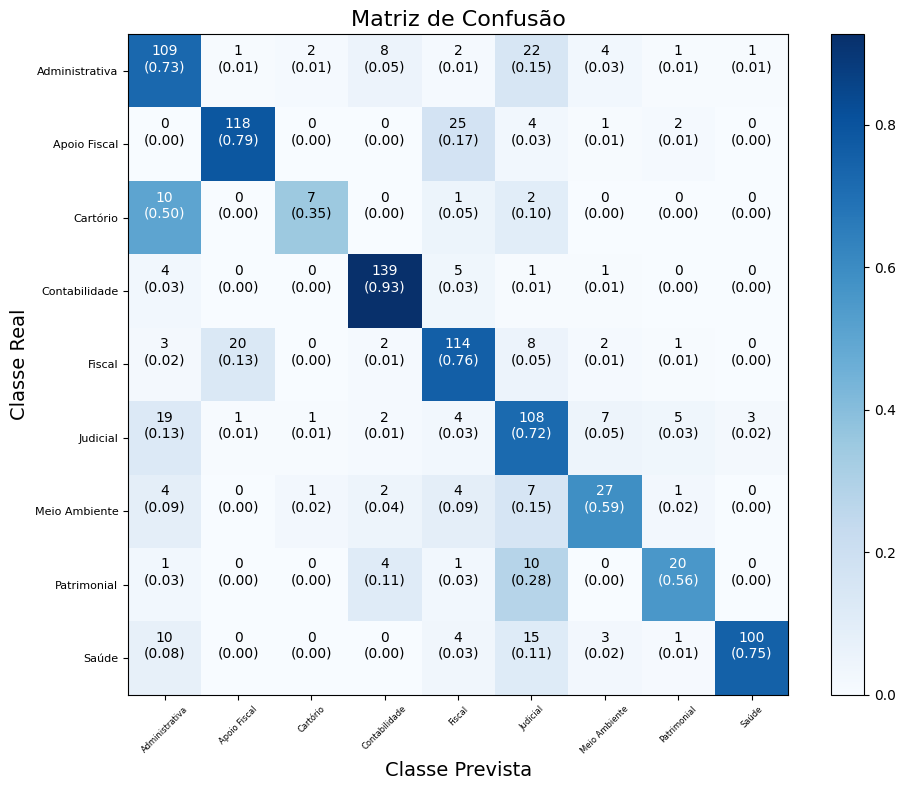

In [91]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=np.unique(y_train))

## 4.7 - Classificação Random Forest

In [92]:
rf_cls = RandomForestClassifier()

rf_cls.fit(X=X_train_scaled, y=y_train)
y_pred = rf_cls.predict(X=X_test_scaled)

In [93]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                precision    recall  f1-score   support

Administrativa       0.61      0.71      0.66       150
  Apoio Fiscal       0.90      0.88      0.89       150
      Cartório       0.62      0.25      0.36        20
 Contabilidade       0.92      0.95      0.93       150
        Fiscal       0.78      0.83      0.81       150
      Judicial       0.66      0.60      0.63       150
 Meio Ambiente       0.43      0.48      0.45        46
   Patrimonial       0.72      0.50      0.59        36
         Saúde       0.88      0.86      0.87       133

      accuracy                           0.77       985
     macro avg       0.73      0.67      0.69       985
  weighted avg       0.77      0.77      0.76       985



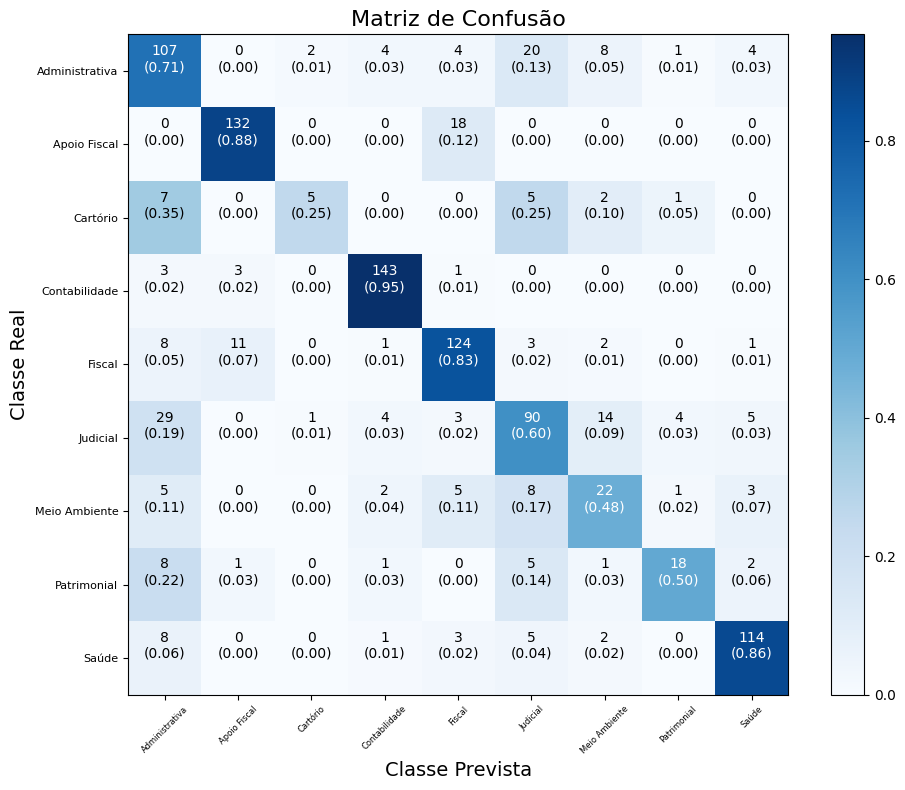

In [94]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=np.unique(y_train))

## 4.8 - Classificação (Decision Tree)

In [95]:
dt_cls = DecisionTreeClassifier()

dt_cls.fit(X=X_train_scaled, y=y_train)
y_pred = dt_cls.predict(X=X_test_scaled)

In [96]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                precision    recall  f1-score   support

Administrativa       0.59      0.73      0.65       150
  Apoio Fiscal       0.81      0.79      0.80       150
      Cartório       0.35      0.40      0.37        20
 Contabilidade       0.93      0.91      0.92       150
        Fiscal       0.71      0.67      0.69       150
      Judicial       0.70      0.57      0.63       150
 Meio Ambiente       0.41      0.48      0.44        46
   Patrimonial       0.46      0.53      0.49        36
         Saúde       0.82      0.79      0.80       133

      accuracy                           0.71       985
     macro avg       0.64      0.65      0.64       985
  weighted avg       0.72      0.71      0.72       985



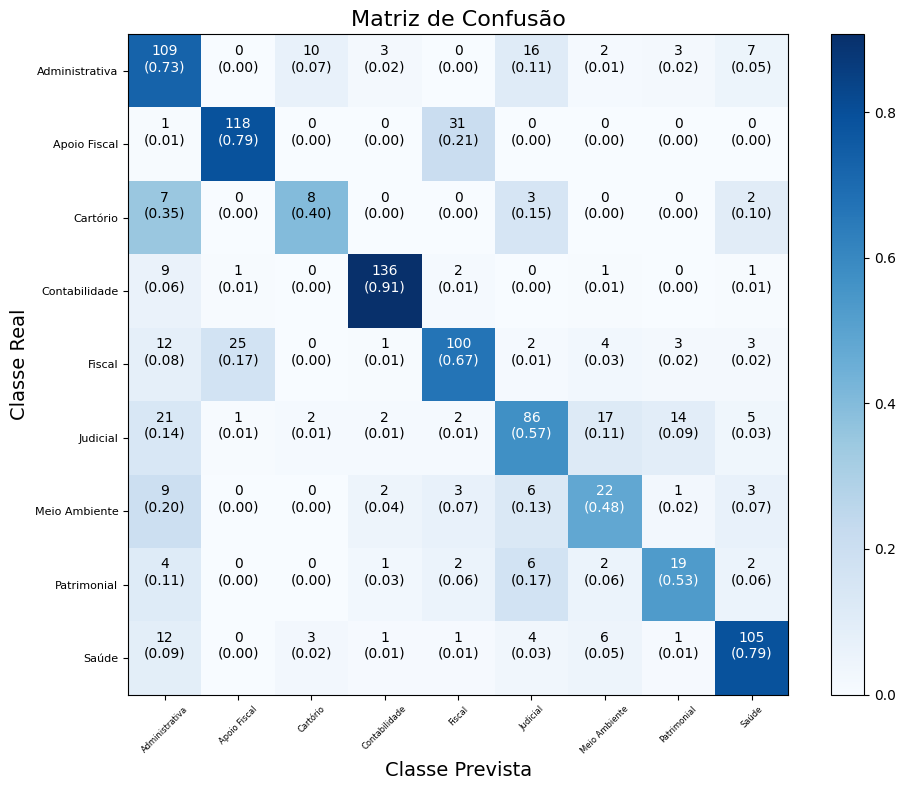

In [97]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=np.unique(y_train))

In [19]:
separa_assuntos_documentos(df['anexos'])

Número de assuntos/documentos: 134994


KeyboardInterrupt: 